<a href="https://colab.research.google.com/github/mavito/ML_Concepts/blob/main/ML_ClassificationSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification using Support Vector Machines**

### **1.1 The Geometry of Hyperplanes and Decision Boundaries**

Imagine a large, flat table covered in marbles. Some marbles are blue, and some are red. Your task is to place a single, straight stick across the table such that all blue marbles are on one side and all red marbles are on the other.In this analogy:
- The Table represents our 2D feature space.
- The Marbles are the data points.
- The Stick is the hyperplane (decision boundary).
- The Angle of the Stick represents the vector $\mathbf{w}$. If you rotate the stick, you are changing $\mathbf{w}$.
- The Position of the Stick (sliding it back and forth without rotating) represents the bias $b$.

If the marbles are mixed together in a complex pattern, you cannot separate them with a straight stick. However, if they are separated into two distinct clusters, you can place the stick between them. This condition is called "Linear Separability." The SVM algorithm is essentially a robotic arm trying to find the absolute best place to put that stick.

**Visualizing Hyperplanes**

This code demonstrates how changing $\mathbf{w}$ and $b$ affects the boundary. We use specific, hard-coded values to guarantee a working example.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_separator_demonstration():
    """
    Demonstrates the concept of a separating hyperplane with fixed values.
    Students can see how the line w^T x + b = 0 separates data.
    """
    # 1. Create a simple, linearly separable dataset
    # We have two features (x1, x2) for each point.
    # Class +1 (Blue) centers around (8, 8)
    # Class -1 (Red) centers around (2, 2)
    X = np.array([2.0, 2.0], [2.5, 3.0], [1.5, 2.5], [3.0, 1.0],  # Red Class (-1)
        [8.0, 8.0], [8.5, 7.5], [7.0, 8.0], [9.0, 9.0]   # Blue Class (+1)
    )
    y = np.array([-1, -1, -1, -1, 1, 1, 1, 1])

    # 2. Define a candidate hyperplane
    # w =  implies a 45-degree normal vector pointing top-right.
    # b = -10 shifts the line. The equation is 1*x1 + 1*x2 - 10 = 0.
    w_example = np.array([1.0, 1.0])
    b_example = -10.0

    # 3. Visualization Logic
    plt.figure(figsize=(8, 6))

    # Plot Class -1 (Red)
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1', s=100)
    # Plot Class +1 (Blue)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class +1', s=100)

    # Generate points for the line
    # Equation: w1*x1 + w2*x2 + b = 0  =>  x2 = -(w1*x1 + b) / w2
    x1_vals = np.linspace(0, 10, 100)
    x2_vals = -(w_example * x1_vals + b_example) / w_example

    plt.plot(x1_vals, x2_vals, 'k--', linewidth=2, label='Hyperplane: x1 + x2 - 10 = 0')

    # Annotate the Normal Vector w
    # We start the arrow at the midpoint of the line for visualization
    mid_idx = len(x1_vals) // 2
    start_point = (x1_vals[mid_idx], x2_vals[mid_idx])
    plt.arrow(start_point, start_point, w_example, w_example,
              head_width=0.3, head_length=0.3, fc='green', ec='green', label='Normal Vector w')

    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.xlabel('Feature x1')
    plt.ylabel('Feature x2')
    plt.title('Visualizing a Separating Hyperplane')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Verification Check
    # We calculate w^T x + b for all points to prove they are separated.
    # Positive class should be > 0, Negative class should be < 0.
    print("Verification of Separation:")
    for i in range(len(X)):
        val = np.dot(w_example, X[i]) + b_example
        result = "Correct" if np.sign(val) == np.sign(y[i]) else "Incorrect"
        print(f"Point {X[i]} (Label {y[i]}): Value = {val:.2f} -> {result}")

plot_separator_demonstration()

TypeError: array() takes from 1 to 2 positional arguments but 8 were given

## Task 1.1:
You are given a new dataset centered differently.
  - Class A (Label -1): centered at (2, 8).
  - Class B (Label +1): centered at (8, 2).

1. Create a new numpy array for this dataset.
2. Your task is to find a vector $\mathbf{w}$ and scalar $b$ that separates these classes. Hint: Look at the relationship between the x and y coordinates. As x increases, y decreases for the "gap" between them.
3. What does this suggest about the signs of the components in $\mathbf{w}$?
4. Modify the plot_separator_demonstration function to accept w and b as arguments.
5. Iteratively try values until you get a perfect separation (console prints "Correct" for all).

In [ ]:
#WRITE CODE HERE

**1.2 The Concept of the Margin**

We introduce the "Widest Street" analogy (sometimes attributed to MIT Professor Patrick Winston).

Imagine the data points are houses in two different neighborhoods: Redville and Bluetown. The city planner wants to build a new highway (the hyperplane) separating them.

- **Safety Requirement:** To ensure safety and reduce noise, the planner wants the highway to be as wide as possible.

- **The Gutters:** The edges of the paved road are the "gutters." The distance from the center line to the gutter is the margin.

- **Constraint:** The planner expands the road until it hits the front porch of the very first house. It cannot go any wider without demolishing a house (which is forbidden in Hard Margin SVM).

- **Support Vectors:** The specific houses that physically block the road from getting wider are the Support Vectors. They "support" the road. If you moved a house in the back of the neighborhood, the road width wouldn't change. But if you move one of the houses on the edge, the road width changes.

This analogy explains why SVMs are robust. They don't care about the billions of data points deep inside the cluster; they only care about the difficult cases at the boundary.   

*This snippet calculates the geometric margin for a given $\mathbf{w}, b$ and dataset.*


In [5]:
def calculate_margin(w, b, X, y):
    """
    Calculates the geometric margin of the classifier (w, b) on dataset (X, y).
    The margin is the distance to the CLOSEST point.
    """
    # 1. Calculate distances for all points
    # The algebraic distance is y * (w.x + b)
    # We want these to be positive for correct classification.
    algebraic_distances = y * (np.dot(X, w) + b)

    # 2. Check if the separator is valid
    if np.any(algebraic_distances < 0):
        print("Warning: The hyperplane does not separate the data!")
        return 0.0

    # 3. Geometric distance is algebraic distance normalized by ||w||
    norm_w = np.linalg.norm(w)
    geometric_distances = algebraic_distances / norm_w

    # 4. The margin is the minimum of these distances
    margin = np.min(geometric_distances)

    print(f"Norm of w: {norm_w:.4f}")
    print(f"Closest point distance (Margin): {margin:.4f}")
    return margin

# Example Usage with previous valid w and b
# Data from previous example
X_margin = np.array([2.0, 2.0], [2.5, 3.0], [1.5, 2.5], [3.0, 1.0],
        [8.0, 8.0], [8.5, 7.5], [7.0, 8.0], [9.0, 9.0])
y_margin = np.array([-1, -1, -1, -1, 1, 1, 1, 1])
w_margin = np.array([1.0, 1.0])
b_margin = -10.0

calculate_margin(w_margin, b_margin, X_margin, y_margin)

TypeError: array() takes from 1 to 2 positional arguments but 8 were given

## Task 1.2:

- Use the calculate_margin function on the dataset provided.

- Try three different hyperplanes that all separate the data:
  - H1: w = , b = -10
  - H2: w = [0.5, 0.5], b = -5 (Note: This is the same line mathematically, check the margin!)
  - H3: w = [1, 0.8], b = -9 (A slightly rotated line).
- Record the margin for each. Which one is effectively wider?
- Why did H1 and H2 give the same/different results? (Explain how scaling $\mathbf{w}$ affects the calculation).

## **2. The Primal Formulation (Hard Margin)**

Imagine you are an architect submitting a design for the highway.
- The City Council (the constraints) has a strict rule: "Every house must be at least 1 meter away from the road center."
- The Construction Company (the objective function) has a rule: "Use the minimum amount of asphalt possible." (Minimizing $\mathbf{w}$ minimizes the resources used to define the boundary complexity).

The Hard Margin SVM is an architect who refuses to compromise. They will try to make the road as efficient as possible, but if a single house blocks the path, they will say, "Impossible! I cannot build this." They will not tear down the house, and they will not bend the rule.  

**Solving the Primal with cvxopt**

*we use a generic convex optimization solver (cvxopt or scipy.optimize). This demonstrates that SVMs are just a specific instance of a general math problem.*

In [8]:
import numpy as np
from scipy.optimize import minimize

def solve_hard_margin_primal(X, y):
    """
    Solves the Primal SVM problem using numerical optimization.
    Minimize 0.5 * ||w||^2 subject to y*(w.x + b) >= 1
    """
    n_features = X.shape

    # 1. Define the Objective Function
    # params is a vector [w1, w2,..., wn, b]
    # We want to minimize 0.5 * sum(w^2)
    # Note: We do NOT penalize b in the objective.
    def objective(params):
        w = params[:n_features]
        return 0.5 * np.sum(w**2)

    # 2. Define Constraints
    # Scipy expects constraints in the form: fun(params) >= 0
    # Our constraint: y_i(w.x_i + b) - 1 >= 0
    def constraint(params):
        w = params[:n_features]
        b = params[-1]
        # Calculate y * (X.w + b) - 1 for all points
        # The result is an array; all elements must be >= 0
        return y * (np.dot(X, w) + b) - 1

    # 3. Set up the optimizer
    # Initial guess (random or zeros)
    initial_guess = np.zeros(n_features + 1)

    # Define constraint dictionary
    # 'type': 'ineq' means inequality constraint (>= 0)
    cons = {'type': 'ineq', 'fun': constraint}

    # 4. Run Optimization
    # SLSQP is a solver for constrained non-linear problems
    result = minimize(objective, initial_guess, constraints=cons, method='SLSQP')

    if not result.success:
        print("Optimization failed! Data might not be linearly separable.")
        return None, None

    optimal_w = result.x[:n_features]
    optimal_b = result.x[-1]

    return optimal_w, optimal_b

# Test with the clean dataset
X_clean = np.array([, , , ])
y_clean = np.array([-1, -1, 1, 1])

w_opt, b_opt = solve_hard_margin_primal(X_clean, y_clean)
print(f"Optimization Result:\n w = {w_opt}\n b = {b_opt}")

# Calculate margin width = 2 / ||w||
margin_width = 2 / np.linalg.norm(w_opt)
print(f"Maximized Margin Width: {margin_width:.4f}")

TypeError: array() takes from 1 to 2 positional arguments but 4 were given

## Task 2.1 : Breaking the Hard Margin

- Run the code on the clean dataset provided. Record the w and b.

- Introduce a single "outlier" point that makes the data non-separable. Add a point `` with label -1 (placing it right in the middle of the gap, or slightly on the Blue side).

- Run the solve_hard_margin_primal function again.

- Observe the failure message or the nonsensical results.

In your own words, explain why the SLSQP solver could not find an answer. Relate this back to the "Strict Architect" analogy.

In [ ]:
#WRITE CODE HERE

## **3. Handling Noise (Soft Margin and Regularization)**

Since Hard Margin SVM fails on noisy data, we introduce flexibility. We modify the constraints to allow points to violate the margin. We introduce slack variables $\xi_i$ (Greek letter Xi, often read as "zeta" in layman contexts), and $C$ (the Regularization Parameter)

The SVM is a teacher, and the data points are students taking an exam.
- The Margin is the passing grade (e.g., 60%).
- Slack $\xi$ is the number of points a student is missing to reach the safe zone. If a student scores 55%, they have a slack of 5%. If they score 10%, they have a massive slack.
- Parameter C is the Strictness of the School Board.
  - Strict Board (High C):
    - "Every point lost by a student costs the teacher \$100."
    - The teacher will contort the curriculum (the hyperplane) wildly to ensure every single student passes, even the one who slept through class.
    - This creates a weird, wavy curriculum that won't help next year's class (Overfitting).
  - Lenient Board (Low C):
    - "We don't care much about individual failures; just keep the curriculum simple."
    - The teacher draws a straight, simple line.
    - Some students fail ($\xi > 0$), but the curriculum is solid and understandable for the majority.

*We now switch to scikit-learn to visualize the effect of $C$, as writing a primal solver for Soft Margin is complex for undergraduates.*

In [9]:
from sklearn.svm import SVC

def visualize_soft_margin(C_values):
    """
    Trains SVMs with different C values on a noisy dataset.
    """
    # 1. Create a noisy dataset (overlapping blobs)
    # We define points that clearly overlap in the middle
    X_noisy = np.array(, , , ,  # Class -1
        [1.5, 1.5],                      # Noise point from Class -1 inside Class +1 region
        , , ,    # Class +1
    ])
    y_noisy = np.array([-1, -1, -1, -1, -1, 1, 1, 1, 1])

    plt.figure(figsize=(15, 5))

    for i, C_val in enumerate(C_values):
        # 2. Train SVM
        clf = SVC(kernel='linear', C=C_val)
        clf.fit(X_noisy, y_noisy)

        # 3. Plotting logic
        plt.subplot(1, len(C_values), i+1)
        plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c=y_noisy, cmap='coolwarm', s=50)

        # Plot the decision boundary and margins
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Create grid to evaluate model
        xx = np.linspace(xlim, xlim, 30)
        yy = np.linspace(ylim, ylim, 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack().T
        Z = clf.decision_function(xy).reshape(XX.shape)

        # Plot decision boundary and margins
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])

        # Highlight Support Vectors
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                   linewidth=1.5, facecolors='none', edgecolors='k')

        plt.title(f'C = {C_val}')

    plt.show()

# Run the visualization
visualize_soft_margin([0.1, 1.0, 1000.0])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 9 (ipython-input-2766803799.py, line 12)

## Task 3.1

1. Run the code.
2. Identify which plot corresponds to the "Strict Teacher" and which to the "Lenient Teacher."
3. Modify the dataset to have two noise points.
4. Find a value of C where the model classifies one noise point correctly but ignores the other. (This teaches sensitivity tuning).

## **4. Lagrange Multipliers and the Dual**

Why do we need another formulation? The Primal form scales with the number of features (dimensions) $D$. If we map data to a million-dimensional space (as we will in Module 5), the Primal becomes computationally expensive. The Dual Formulation scales with the number of data points $N$ and depends only on dot products between points. This is the key to the "Kernel Trick."

Imagine the two classes are teams in a multi-dimensional Tug-of-War.
- The Rope is the weight vector $\mathbf{w}$.
- Each data point $\mathbf{x}_i$ is a person pulling on the rope.
- The coefficient $\alpha_i$ is how hard that person is pulling.

Here is the catch: In a balanced game (the optimal solution), most people are lazy. They don't pull at all ($\alpha_i = 0$). These are the points far away from the boundary. They are irrelevant to the outcome.
The only people who pull are the ones right at the front lines, staring at the opponent. These are the Support Vectors ($\alpha_i > 0$). They define the tension and direction of the rope. The Dual formulation is simply a mathematical way of figuring out who is pulling and how hard.

*We will inspect the dual_coef_ attribute of a trained model to prove the "Tug-of-War" analogy.*

In [10]:
def inspect_dual_coefficients():
    # 1. Train a model on simple data
    X = np.array([, , , ])
    y = np.array([-1, -1, 1, 1])

    # Use a linear kernel
    clf = SVC(kernel='linear', C=10)
    clf.fit(X, y)

    # 2. Extract Support Vector Information
    support_vector_indices = clf.support_
    support_vectors = clf.support_vectors_
    dual_coefs = clf.dual_coef_ # This is alpha_i * y_i

    print("Total Data Points:", len(X))
    print("Number of Support Vectors:", len(support_vectors))
    print("-" * 30)

    print("Support Vectors and their 'Pulling Strength' (alpha):")
    for i, idx in enumerate(support_vector_indices):
        # recover alpha from dual_coef (which is alpha * y)
        alpha = abs(dual_coefs[i])
        point = X[idx]
        label = y[idx]
        print(f"Point {point} (Label {label}): Alpha = {alpha:.4f}")

    print("-" * 30)
    print("Non-Support Vectors (Alpha = 0):")
    all_indices = set(range(len(X)))
    sv_indices = set(support_vector_indices)
    non_sv = all_indices - sv_indices
    for idx in non_sv:
        print(f"Point {X[idx]}")

inspect_dual_coefficients()

SyntaxError: invalid syntax (ipython-input-118727403.py, line 3)

## Task 4

1. Run the code above with C=10 (Hard Margin behavior). Note how many support vectors there are.

2. Change C to 0.01 (Soft Margin behavior).

3. Run it again. Hypothesis: Will the number of support vectors increase or decrease?

*Hint: If the street gets wider (low C), does it touch more houses or fewer houses?*

Write down your observation and explain it using the "Street" analogy.

In [ ]:
#WRITE CODE HERE

## **5. The Kernel Trick**

Linear SVMs are powerful, but what if the data looks like a target (concentric circles)? No straight line can separate a red inner circle from a blue outer ring. To solve this, we project the data into a higher-dimensional space where it is linearly separable.

Imagine the data points are ink dots on a flat sheet of paper. Red dots are in the center, Blue dots are in a ring around them. You cannot draw a straight line to separate them.

The Kernel Trick is like 3D Origami:

1. Imagine grabbing the center of the paper (where the red dots are) and pulling it upwards.

2. You have created a paper cone or a mountain. The red dots are at the peak. The blue dots are at the base.   

3. Now, take a flat sheet of plastic (the hyperplane) and slice it horizontally through the mountain.

4. The plastic sheet separates the peak (Red) from the base (Blue) perfectly.

5. If you look at the shadow of that cut back on the table, it looks like a circle!

We created a circular boundary in 2D by building a linear boundary in 3D. The "Trick" is that we don't need to physically build the mountain; the Kernel function calculates the "height" differences mathematically.   

**Custom Kernel Visualization**

*We will manually implement a feature map to show exactly how "lifting" works, then use the built-in kernel.*

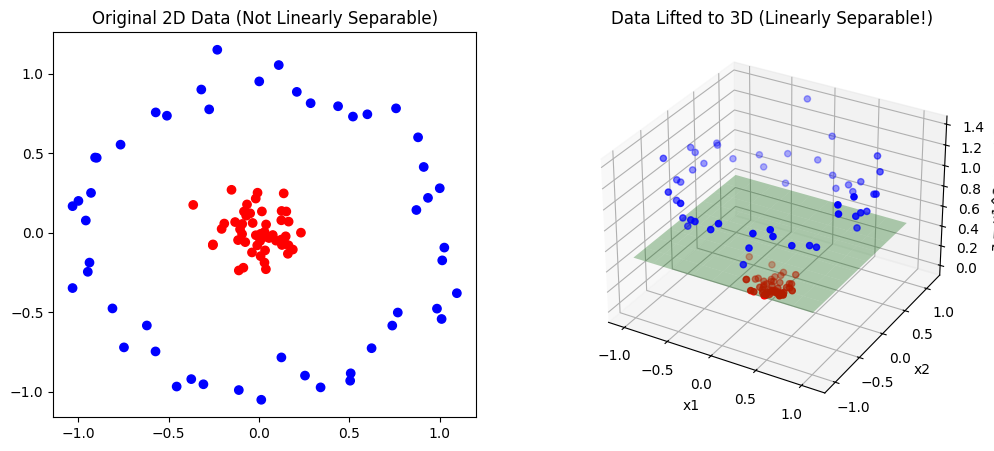

In [11]:
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D

def demonstrate_kernel_trick():
    # 1. Generate Non-linear Data (Circles)
    X, y = make_circles(n_samples=100, factor=0.1, noise=0.1)

    # 2. Visualize in 2D (Failure of Linear)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
    plt.title("Original 2D Data (Not Linearly Separable)")

    # 3. Apply Manual Feature Mapping (Lifting to 3D)
    # New feature z = x^2 + y^2 (Distance from origin squared)
    z = X[:, 0]**2 + X[:, 1]**2

    # 4. Visualize in 3D
    ax = plt.subplot(1, 2, 2, projection='3d')
    # Plot Red class (inner)
    ax.scatter(X[y==0, 0], X[y==0, 1], z[y==0], c='blue', label='Class 0')
    # Plot Blue class (outer)
    ax.scatter(X[y==1, 0], X[y==1, 1], z[y==1], c='red', label='Class 1')

    # Draw the separating plane (z = threshold)
    # Visually, a cut at z=0.5 should work
    xx, yy = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
    zz = np.full_like(xx, 0.5)
    ax.plot_surface(xx, yy, zz, alpha=0.3, color='green')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('z = x1^2 + x2^2')
    plt.title("Data Lifted to 3D (Linearly Separable!)")
    plt.show()

demonstrate_kernel_trick()

## Task 5 : RBF Kernel Exploration

1. Run the code to see the 3D lift.

2. Now use `sklearn.svm.SVC` with `kernel='rbf'`.

3. The RBF kernel has a parameter gamma (inverse of the width of the Gaussian).

4. Train and plot the decision boundary (2D) for gamma=0.1, gamma=1.0, and gamma=100.0.

5. Which gamma value creates "islands" around specific points (Overfitting), and which creates a smooth blob (Underfitting)? Relate gamma to the "sharpness" of the mountain peak in the paper folding analogy.

## **6. Sequential Minimal Optimization**

Imagine a team of climbers (the alphas) tied together by a rope (the constraint $\sum \alpha y = 0$). They want to reach the highest combined altitude (maximize the dual objective).

If Climber A wants to move up, Climber B might have to move down to keep the rope taut and balanced. They cannot move individually.

The SMO algorithm is the strategy where the team leader picks two climbers at a time and says, "You two, adjust your positions to get higher while keeping the rope tight." Then they pick another two.

By making these small, easy pairwise adjustments, the whole team eventually reaches the peak.

*Implementing a full SMO is too code-heavy for a basic assignment, so we simulate the selection process.*

In [12]:
import random

def simplified_smo_concept(y):
    """
    Demonstrates the pairing constraint of SMO.
    We must update alphas such that sum(alpha * y) remains 0.
    """
    # Initialize random alphas
    N = len(y)
    alpha = np.zeros(N)

    # Let's say we pick indices 0 and 1 to update
    i, j = 0, 1

    # Current state
    # Constraint: alpha[i]*y[i] + alpha[j]*y[j] = constant (k)
    # We ignore other alphas for a moment

    # Simulation: We want to increase alpha[i] by a step
    step = 0.5
    old_ai = alpha[i]
    old_aj = alpha[j]

    # Update alpha[i]
    alpha[i] += step

    # To satisfy y[i]*a[i] + y[j]*a[j] = C, we must adjust alpha[j]
    # delta_ai * y[i] + delta_aj * y[j] = 0
    # delta_aj = - delta_ai * y[i] / y[j]

    delta_ai = step
    delta_aj = -delta_ai * y[i] / y[j]
    alpha[j] += delta_aj

    print(f"Update: Index {i} changed by {delta_ai}, Index {j} changed by {delta_aj}")
    print(f"Did we maintain constraint? {old_ai*y[i] + old_aj*y[j] == alpha[i]*y[i] + alpha[j]*y[j]}")

y_sim = np.array([1, -1, 1, -1])
simplified_smo_concept(y_sim)

Update: Index 0 changed by 0.5, Index 1 changed by 0.5
Did we maintain constraint? True


## Task 6.1 :
1. Run the simulation.
2. If y[i] and y[j] are the same (both +1), and you increase alpha[i], what must happen to alpha[j]? (Increase or Decrease?)
3. If they are different (+1 and -1), what happens?
4. Why does this make the optimization easier than changing all 1000 alphas at once?